- https://teramonagi.hatenablog.com/entry/20120930/1348982608 "レプリカ交換モンテカルロ法（パラレル・テンパリング）による混合ガウス分布に従う乱数の生成"

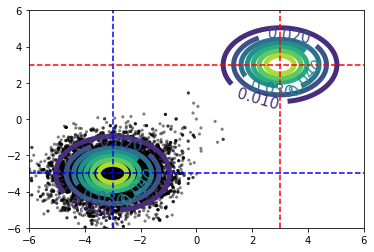

[-3.00192651 -2.97679264]


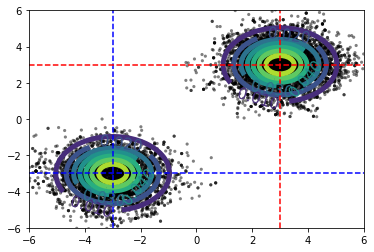

[0.34643069 0.35268761]


In [4]:
import numpy as np
import matplotlib.pyplot as plt

#標準多変量正規分布
def standard_multivariate_normal_pdf(x):
    x = np.asarray(x)    
    return 1.0/(2.0*np.pi)**(len(x)/2.0)*np.exp(-0.5*np.dot(x,x))

#混合ガウシアンの平均値を指定して生成する関数
def generate_equilibrium_distribution(mu):
    #定常分布（混合ガウシアン）
    def equilibrium_distribution(x):    
        x = np.asarray(x)
        #混合比率(5:5で混ぜる)
        theta = np.array((0.5, 0.5))
        #２つのガウシアンの確率密度（平均(mu,mu), (-mu,-mu)の２つ）
        p1 = standard_multivariate_normal_pdf(x-np.array(( mu,  mu)))
        p2 = standard_multivariate_normal_pdf(x-np.array((-mu, -mu)))
        #混合分布の確率密度
        return np.dot(theta, np.array((p1,p2)))
    return equilibrium_distribution

#MCMC(メトロポリス法）による次候補生成
def next_with_metropolis_algorithm(x,equilibrium_distribution):
    #次の位置の候補の作成    
    x_proposed = x + 0.5*np.random.normal(size=len(x))
    #メトロポリスアルゴリズムに従って候補の棄却・採用判定を行う    
    if(np.random.uniform(size=1) < equilibrium_distribution(x_proposed)/equilibrium_distribution(x)):
        return x_proposed
    else:
        return x
    
#通常のマルコフ連鎖モンテカルロ法による分布生成
def mcmc_normal(mu, size_simulation):
    #定常分布の平均値（(-mu,-mu）,(mu,mu))設定
    equilibrium_distribution = generate_equilibrium_distribution(mu)    
    #初期スタート位置
    x = np.array([[0,0]])    
    for i in range(size_simulation):
        x = np.vstack((x, next_with_metropolis_algorithm(x[-1],equilibrium_distribution)))
    return x

#レプリカ交換モンテカルロ法による分布生成
def mcmc_replica_exchange(mu, size_simulation, size_replica, frequency_exchange):
    #初期スタート位置
    x = [[np.random.uniform(-mu,mu,2)] for i in range(size_replica)]
    #適当に間を切って定常分布"族"生成
    equilibrium_distributions = [generate_equilibrium_distribution(var) for var in np.linspace(0,mu,num=size_replica)]
    #シミュレーション    
    for i in range(size_simulation):
        #通常のMCMCシミュレーション（メトロポリス法）
        for index_replica in range(size_replica):
            x_next = next_with_metropolis_algorithm(x[index_replica][-1],equilibrium_distributions[index_replica])
            x[index_replica] = np.vstack((x[index_replica], x_next))
        #適当な交換頻度に応じたレプリカの交換
        if(i % frequency_exchange == 0):
            index_exchange = int(np.random.uniform(0,size_replica-1))
            x1 = x[index_exchange  ][-1]                
            x2 = x[index_exchange+1][-1]
            eq_dist1 = equilibrium_distributions[index_exchange]            
            eq_dist2 = equilibrium_distributions[index_exchange+1]            
            #メトロポリスアルゴリズムに従って状態交換の採択・棄却判定
            if(np.random.uniform(size=1) < (eq_dist1(x2)*eq_dist2(x1))/(eq_dist1(x1)*eq_dist2(x2))):
                x[index_exchange][-1], x[index_exchange+1][-1] = np.copy(x2),np.copy(x1)
    return x[size_replica-1]

#サンプルの散布図　＆　真の確率密度の等高線
def plot_result(x, mu):    
    equilibrium_distribution = generate_equilibrium_distribution(MU)    
    axis_range = mu+3.0
    #散布図
    plt.scatter(x[:,0],x[:,1],c="black",s=10,edgecolors="None",alpha=0.5)    
    #等高線（真の確率密度から計算）
    mesh = np.arange(-axis_range,axis_range,0.1)
    X,Y = np.meshgrid(mesh, mesh)
    Z = np.zeros(np.shape(X))
    for i in range(np.size(X,0)):
        for j in range(np.size(X,1)):
            Z[i,j] = equilibrium_distribution((X[i,j],Y[i,j]))
    CS = plt.contour(X,Y,Z,linewidths=5)
    plt.clabel(CS,fontsize=15)
    #各ガウシアンの平均値が見やすいように適用に線を入れる    
    plt.axvline(x= mu,c='r',ls='--')
    plt.axvline(x=-mu,c='b',ls='--')
    plt.axhline(y= mu,c='r',ls='--')
    plt.axhline(y=-mu,c='b',ls='--')
    plt.axis([-axis_range, axis_range,-axis_range, axis_range])
    plt.show()
#
if __name__ == "__main__":
    #定常分布にしたい混合ガウシアンの平均値(２つのガウシアンにおいて(mu,mu), (-mu,-mu)が平均となる)
    MU = 3.0
    #レプリカの個数
    SIZE_REPLICA = 5
    #何ステップに一回状態交換を計算するか
    FREQUENCY_EXCHANGE = 20
    #シミュレーション回数
    SIZE_SIMULATION= 10000

    #通常のマルコフ連鎖モンテカルロ法による混合ガウス分布生成
    x = mcmc_normal(MU,SIZE_SIMULATION)
    plot_result(x, MU) 
    print(np.mean(x, axis=0))

    #レプリカ交換モンテカルロ法による混合ガウス分布生成
    x = mcmc_replica_exchange(MU,SIZE_SIMULATION,SIZE_REPLICA,FREQUENCY_EXCHANGE)
    plot_result(x, MU)
    print(np.mean(x, axis=0))